# Generative Models PHW4: Normalizing Flows

Name: Firoozeh Abrishami

Student ID: 402208716

## Setup

In [35]:
# Import necessary libraries
import os
import random
import numpy as np
from tqdm import trange
import imageio.v2 as imageio
from matplotlib import pyplot as plt
from typing import Callable, Optional, Tuple, Union, List
from IPython.display import Image, display

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset


from sklearn.datasets import make_moons, make_circles

In [36]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cpu device


In [37]:
# @title visualization helpers

def visualize(flow, epoch, output_dir='frames', device='cpu'):
    # Create directory for saving frames
    os.makedirs(output_dir, exist_ok=True)

    # Visualization of the learned density
    with torch.no_grad():
        # Create a grid over the range of the data
        xline = torch.linspace(-2, 3, 300, device=device)
        yline = torch.linspace(-1, 1.5, 300, device=device)
        xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
        xyinput = torch.cat([xgrid.reshape(-1, 1),
                             ygrid.reshape(-1, 1)], dim=1).to(device)

        # Compute the log probability for each point in the grid
        log_prob_grid = flow.log_prob(xyinput)  # Compute log probs
        zgrid = torch.exp(log_prob_grid).reshape(300, 300).cpu()  # Convert to probability

        # Plot the density
        plt.figure(figsize=(8, 6))
        plt.contourf(
            xgrid.cpu().numpy(),
            ygrid.cpu().numpy(),
            zgrid.numpy(),
            levels=50,
            cmap='viridis'
        )
        plt.title(f'Learned Density at Epoch {epoch}')
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.colorbar(label='Density')

        # Save frame as an image
        filename = os.path.join(output_dir, f'frame_{epoch:03d}.png')
        plt.savefig(filename)
        plt.close()

def create_gif(output_dir='frames', gif_name='density_evolution.gif', fps=10):
    images = []
    for frame in sorted(os.listdir(output_dir)):
        if frame.endswith(".png"):
            images.append(imageio.imread(os.path.join(output_dir, frame)))
    imageio.mimsave(gif_name, images, fps=fps)
    display(Image(filename=gif_name))
    return gif_name

# Dataset (5 points)

Create moons using the `make_moons` dataset from `sklearn.datasets`. You must use `TensorDataset` to create a `DataLoader` for this dataset.

In [38]:
# Generate dataset
X, _ = make_moons(n_samples=1000, noise=0.1)
X = torch.tensor(X, dtype=torch.float32)

# DataLoader
dataset = TensorDataset(X)
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Transformations (30 points)

One of the challenges in creating flow models is creating invertible transformations. Also we would like it if computation of their inverse and/or the log determinant of their jacobian were simple.

In [39]:
class Transform(nn.Module):
    """Base class for all transform objects."""
    def __init__(self):
        super().__init__()

    def forward(self, inputs, context=None):
        raise NotImplementedError()

    def inverse(self, inputs, context=None):
        raise 'InverseNotAvailable'

First we can create a random permutation transform.

In [40]:
class PermutationTransform(Transform):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        permutation = torch.randperm(num_features)
        self.register_buffer('permutation', permutation)
        self.register_buffer('inverse_permutation', torch.argsort(permutation))

    def forward(self, inputs, context=None):
        return inputs[:, self.permutation], 0  # Log-det is zero

    def inverse(self, inputs, context=None):
        return inputs[:, self.inverse_permutation]

Now you must:

1. **Scaling and Translation Networks**:
	- Use `self.s_net_factory` and `self.t_net_factory` to initialize the scaling (`s`) and translation (`t`) networks in the `__init__` method.

2. **Forward Pass**:
	-	Pass fixed_inputs through `self.scaling_net` and `self.translation_net` to compute `s` and `t`.

	-	Apply the transformations to `transformed_inputs`.

  - Compute the log-determinant of the Jacobian.

3. **Inverse Pass**:
	-	Solve for `transformed_inputs` by reversing the scaling and translation.

4. **Utility Method **`_initialize_network`:
	-	Use `nn.Sequential`to create a feedforward neural network with the desired hidden dimensions and activation functions.

In [41]:
class CouplingTransform(Transform):
    def __init__(self,
                 num_features: int,
                 hidden_dim: int,
                 mask: torch.Tensor,
                 s_net_factory: Callable[[int, int, int], nn.Module],
                 t_net_factory: Callable[[int, int, int], nn.Module]):
        super().__init__()

        self.num_features = num_features
        self.mask = mask
        self.scaling_net = self._initialize_network(num_features // 2, num_features // 2, hidden_dim, 0)
        self.translation_net = self._initialize_network(num_features // 2, num_features // 2, hidden_dim, 1)

    def _initialize_network(self, in_dim, out_dim, hidden_dim, t):
        layers = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.Tanh() if t == 1 else nn.Identity()
        )
        return layers


    def forward(self, inputs, context=None):
        # Split the inputs based on the mask
        fixed_inputs = inputs[:, self.mask == 0]
        transformed_inputs = inputs[:, self.mask == 1]

        # Compute scaling and translation factors
        s = self.scaling_net(fixed_inputs)
        t = self.translation_net(fixed_inputs)

        # Apply transformations
        # Applying tanh to s to constrain its output. This will prevent extreme scaling values, which can lead to numerical instability.
        transformed_inputs = transformed_inputs * torch.exp(torch.tanh(s)) + t

        # Concatenate the transformed and fixed inputs
        outputs = torch.zeros_like(inputs)
        outputs[:, self.mask == 0] = fixed_inputs
        outputs[:, self.mask == 1] = transformed_inputs

        # Compute the log determinant of the Jacobian
        # Adjusting the log determinant calculation to account for tanh
        log_det_J = torch.sum(torch.log(torch.exp(torch.tanh(s))), dim=1)

        return outputs, log_det_J

    def inverse(self, inputs, context=None):
        # Split the inputs based on the mask
        fixed_inputs = inputs[:, self.mask == 0]
        transformed_inputs = inputs[:, self.mask == 1]

        # Compute scaling and translation factors
        s = self.scaling_net(fixed_inputs)
        t = self.translation_net(fixed_inputs)

        # Invert the transformations
        # Using tanh in the inverse as well to maintain consistency and invertibility
        transformed_inputs = (transformed_inputs - t) * torch.exp(-torch.tanh(s))

        # Concatenate the transformed and fixed inputs
        outputs = torch.zeros_like(inputs)
        outputs[:, self.mask == 0] = fixed_inputs
        outputs[:, self.mask == 1] = transformed_inputs

        return outputs

In [42]:
# class CouplingTransform(Transform):
#     """
#     Implements a coupling layer for a normalizing flow model.
#     It splits the input features into two groups based on a binary mask.
#     One group remains unchanged while the other is transformed.
#     """

#     def __init__(
#         self,
#         mask: Union[torch.Tensor, list, tuple],
#         hidden_dims: int,
#         s_net_factory: Optional[Callable[[int, int, int], nn.Module]] = None,
#         t_net_factory: Optional[Callable[[int, int, int], nn.Module]] = None,
#     ):
#         """
#         Args:
#             mask (Union[torch.Tensor, list, tuple]): Binary mask specifying which features to transform.
#                 * If `mask[i] > 0`, `input[i]` will be transformed.
#                 * If `mask[i] <= 0`, `input[i]` will remain unchanged.
#             hidden_dims (int): Number of hidden units for the coupling neural networks.
#             s_net_factory (Callable): Function to create a neural network for the scaling function.
#                 Must take (input_dim, output_dim, hidden_dims) as arguments.
#             t_net_factory (Callable): Function to create a neural network for the translation function.
#                 Must take (input_dim, output_dim, hidden_dims) as arguments.
#         """
#         super().__init__()

#         # Validate and register the binary mask
#         mask = torch.as_tensor(mask, dtype=torch.float32)
#         if mask.dim() != 1:
#             raise ValueError("Mask must be a 1-dimensional tensor.")
#         if mask.numel() == 0:
#             raise ValueError("Mask cannot be empty.")
#         self.register_buffer('mask', mask)

#         # Number of input features
#         self.num_features = mask.numel()

#         # Validate and store the network factories
#         if not callable(s_net_factory) or not callable(t_net_factory):
#             raise ValueError("s_net_factory and t_net_factory must be callable functions.")
#         self.s_net_factory = s_net_factory
#         self.t_net_factory = t_net_factory

#         # Initialize the scaling (s) and translation (t) networks
#         # These will be defined using the factories in the TODO section

#         # TODO: Define the networks (see instructions below)

#     def _initialize_network(
#         self, input_dim: int, output_dim: int, hidden_dims: int
#     ) -> nn.Module:
#         """
#         Utility method to create a neural network.

#         Args:
#             input_dim (int): Number of input features for the network.
#             output_dim (int): Number of output features for the network.
#             hidden_dims (int): Number of hidden units for the network.

#         Returns:
#             nn.Module: A PyTorch neural network.
#         """
#         # TODO: Use this function to initialize scaling and translation networks.
#         pass

#     def forward(self, inputs: torch.Tensor, context: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
#         """
#         Forward pass through the coupling transform.

#         Args:
#             inputs (torch.Tensor): Input tensor of shape (batch_size, num_features).
#             context (Optional[torch.Tensor]): Optional context for conditional transformations.

#         Returns:
#             Tuple[torch.Tensor, torch.Tensor]:
#                 - Transformed inputs of the same shape as the input.
#                 - Log-determinant of the Jacobian of the transformation.
#         """
#         # Validate input dimensions
#         if inputs.dim() != 2:
#             raise ValueError("Inputs must be a 2D tensor.")
#         if inputs.shape[1] != self.num_features:
#             raise ValueError(f"Expected {self.num_features} features, but got {inputs.shape[1]}.")

#         # Split inputs into fixed and transformed groups based on the mask
#         fixed_inputs = inputs * (1 - self.mask)
#         transformed_inputs = inputs * self.mask

#         # TODO: Compute scaling (s) and translation (t) using the neural networks
#         # Use the fixed_inputs as input to the networks
#         # Scale transformed_inputs by exp(s) and shift by t
#         # Optionally: Use tanh or clamp to keep scaling factors bounded

#         z = ...  # Combine fixed_inputs and transformed_inputs to form the output
#         log_det_J = ...  # Compute the log-determinant of the Jacobian

#         return z, log_det_J

#     def inverse(self, inputs: torch.Tensor, context: Optional[torch.Tensor] = None) -> torch.Tensor:
#         """
#         Inverse pass through the coupling transform.

#         Args:
#             inputs (torch.Tensor): Input tensor of shape (batch_size, num_features).
#             context (Optional[torch.Tensor]): Optional context for conditional transformations.

#         Returns:
#             torch.Tensor: Reconstructed inputs of the same shape as the input.
#         """
#         # Validate input dimensions
#         if inputs.dim() != 2:
#             raise ValueError("Inputs must be a 2D tensor.")
#         if inputs.shape[1] != self.num_features:
#             raise ValueError(f"Expected {self.num_features} features, but got {inputs.shape[1]}.")

#         # TODO: Similar to the forward pass, but solve for transformed_inputs
#         # Reverse the scaling and translation operations to reconstruct the input
#         z = ...

#         return z

# Flows (30 points)

You must:

1.	Forward Pass:
	-	Initialize `log_det_J` to 0.
	-	Iterate over `self.transforms` and apply each transform's forward method.

2.	Inverse Pass:
	-	Iterate through `self.transforms` in reverse order and apply each transform's inverse method.
  - Return the final reconstructed input tensor.

3.	Log-Probability:
	-	Use the forward method to get `z` and `log_det_J`.
	- Compute `log_prob_z` using the base distribution's `log_prob` method.
  - Return `log_prob_z + log_det_J`.

4.	Sampling:
	-	Sample z from the base distribution using `self.base_distribution.sample((num_samples,))`.
	-	Map `z` back to the data space using the inverse method.
	-	Return the generated samples.

5.	Sampling and Log-Probability:
	-	Use the sample method to generate samples.
	-	Use the `log_prob` method to compute log-probabilities for the generated samples.
	-	Return both the samples and their log-probabilities.

In [43]:
class Flow(nn.Module):
    def __init__(self, transforms: List[Transform], base_distribution: MultivariateNormal):
        super().__init__()
        self.transforms = nn.ModuleList(transforms)
        self.base_distribution = base_distribution

    def forward(self, inputs, context=None):
        log_det_J = torch.zeros(inputs.shape[0], device=inputs.device)
        z = inputs
        for transform in self.transforms:
            z, ld = transform(z, context)
            log_det_J += ld
        return z, log_det_J

    def inverse(self, inputs, context=None):
        x = inputs
        for transform in reversed(self.transforms):
            x = transform.inverse(x, context)
        return x

    def log_prob(self, inputs, context=None):
        z, log_det_J = self.forward(inputs, context)
        log_prob_z = self.base_distribution.log_prob(z)
        return log_prob_z + log_det_J

    def sample(self, num_samples, context=None):
        z = self.base_distribution.sample((num_samples,))
        return self.inverse(z, context)

    def sample_and_log_prob(self, num_samples, context=None):
        z = self.base_distribution.sample((num_samples,))
        x = self.inverse(z, context)
        log_prob = self.log_prob(x, context)
        return x, log_prob

In [44]:
# class Flow(nn.Module):
#     """
#     Flow-based model that combines a series of invertible transformations
#     with a base distribution for density estimation and sampling.
#     """

#     def __init__(
#         self,
#         transforms: List[nn.Module],
#         base_distribution: Optional[MultivariateNormal] = None
#     ):
#         """
#         Args:
#             transforms (List[nn.Module]): List of invertible transformations (e.g., coupling layers).
#             base_distribution (Optional[MultivariateNormal]): The base distribution.
#                 If None, defaults to a standard multivariate Gaussian.
#         """
#         super().__init__()
#         self.transforms = nn.ModuleList(transforms)
#         self.num_features = self.transforms[0].num_features  # Ensure all transforms share the same input size

#         if base_distribution is None:
#             self.base_distribution = MultivariateNormal(
#                 loc=torch.zeros(self.num_features),
#                 covariance_matrix=torch.eye(self.num_features)
#             )
#         else:
#             self.base_distribution = base_distribution

#     def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#         """
#         Forward pass through the flow model.

#         Args:
#             x (torch.Tensor): Input tensor of shape (batch_size, num_features).

#         Returns:
#             Tuple[torch.Tensor, torch.Tensor]:
#                 - Transformed tensor (latent representation) of the same shape as input.
#                 - Log-determinant of the Jacobian of the entire transformation.
#         """
#         # TODO: Implement the forward pass
#         # 1. Initialize `log_det_J = 0` to accumulate log-determinants of Jacobians.
#         # 2. Iterate through `self.transforms` in order and apply each transform's `forward` method.
#         # 3. Update `log_det_J` with the log-determinant of each transform's Jacobian.
#         # 4. Return the final transformed tensor and accumulated log-determinant.

#         z = ...
#         log_det_J = ...

#         return z, log_det_J

#     def inverse(self, z: torch.Tensor) -> torch.Tensor:
#         """
#         Inverse pass through the flow model.

#         Args:
#             z (torch.Tensor): Latent tensor of shape (batch_size, num_features).

#         Returns:
#             torch.Tensor: Reconstructed input tensor of the same shape as input.
#         """
#         # TODO: Implement the inverse pass
#         # 1. Iterate through `self.transforms` in reverse order and apply each transform's `inverse` method.
#         # 2. Pass `z` sequentially through the inverses of the transforms.
#         # 3. Return the final reconstructed input tensor.

#         x = ...

#         return x

#     def log_prob(self, x: torch.Tensor) -> torch.Tensor:
#         """
#         Compute the log-probability of the input under the flow model.

#         Args:
#             x (torch.Tensor): Input tensor of shape (batch_size, num_features).

#         Returns:
#             torch.Tensor: Log-probabilities of the input under the model.
#         """
#         # TODO: Implement log-probability computation
#         # 1. Apply the forward pass to get `z` (latent representation) and `log_det_J`.
#         # 2. Compute `log_prob_z` using `self.base_distribution.log_prob(z)`.
#         # 3. Return the sum of `log_prob_z` and `log_det_J`.

#         z, log_det_J = ...
#         log_prob_z = ...
#         log_prob = ...

#         return log_prob

#     def sample(self, num_samples: int) -> torch.Tensor:
#         """
#         Generate samples from the flow model.

#         Args:
#             num_samples (int): Number of samples to generate.

#         Returns:
#             torch.Tensor: Samples of shape (num_samples, num_features).
#         """
#         # TODO: Implement sampling
#         # 1. Sample from the base distribution to get `z`.
#         # 2. Apply the inverse pass to map `z` back to the data space.
#         # 3. Return the generated samples.

#         z = ...
#         x = ...

#         return x

#     def sample_and_log_prob(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
#         """
#         Generate samples and their log-probabilities under the flow model.

#         Args:
#             num_samples (int): Number of samples to generate.

#         Returns:
#             Tuple[torch.Tensor, torch.Tensor]:
#                 - Samples of shape (num_samples, num_features).
#                 - Log-probabilities of the samples under the model.
#         """
#         # TODO: Implement sample and log-prob computation
#         # 1. Use `sample` method to generate samples.
#         # 2. Use `log_prob` method to compute the log-probabilities of the samples.
#         # 3. Return both the samples and their log-probabilities.

#         x = ...
#         log_prob = ...

#         return x, log_prob

# Masks (10 points)

Now you should:

1.	Generate the Masks:
	-	Loop through num_masks and alternate between masks starting with 0 or 1.

2.	Output Requirements:
	-	Ensure the output is a list of `torch.Tensor` objects.
	-	Each tensor should be of shape `(num_features,)` and should alternate patterns as described.

In [45]:
def create_alternating_binary_masks(num_features: int, num_masks: int) -> List[torch.Tensor]:
    masks = []
    for i in range(num_masks):
        mask = torch.zeros(num_features)  # Ensuring the shape
        start = i % 2  # Alternate between starting with 0 or 1
        for j in range(num_features):
            if (j + start) % 2 == 0:
                mask[j] = 1
        masks.append(mask)
    return masks

In [46]:
# def create_alternating_masks(num_features: int, num_masks: int) -> List[torch.Tensor]:
#     """
#     Creates a sequence of alternating binary masks for coupling layers in normalizing flows.

#     Args:
#         num_features (int): The number of features in the input.
#         num_masks (int): The number of masks to generate.

#     Returns:
#         List[torch.Tensor]: A list of binary masks. Each mask is a 1D tensor of size `num_features`.
#                             Alternates between masks starting with 0s and masks starting with 1s.
#     """
#     masks = []
#     # TODO:
#     # 1. Loop over `range(num_masks)` to create the required number of masks.
#     # 2. For each mask index `i`:
#     #     - Alternate between starting with 0s (when `i % 2 == 0`) and starting with 1s (when `i % 2 == 1`).
#     #     - For example, if `num_features=6`, the masks might look like:
#     #       [0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0], ...
#     # 3. Convert the mask into a `torch.Tensor` and append it to the `masks` list.
#     # 4. Ensure each mask is of shape `(num_features,)`.

#     return masks

# Training (10 points)

Define the model and it's hyperparameters.

In [47]:
# TODO: Create masks and flow
num_features = 2
num_masks = 5
hidden_dim = 128
lr = 1e-3
num_epochs = 150

masks = create_alternating_binary_masks(num_features, num_masks)

transforms = []
for mask in masks:
    transforms.append(CouplingTransform(num_features=num_features, hidden_dim=hidden_dim, mask=mask,
                                        s_net_factory=CouplingTransform._initialize_network,
                                        t_net_factory=CouplingTransform._initialize_network))

flow = Flow(transforms, base_distribution=MultivariateNormal(torch.zeros(num_features), torch.eye(num_features)))
flow.to(device)


optimizer = optim.Adam(flow.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') # 'min' for minimizing loss

Now train the model. Make sure you run `visualize(flow, epoch)` at each epoch. (If you don't do this you won't be able to visualize the evolution of your model)

In [48]:
# TODO: Train the model

# Training loop
for epoch in trange(num_epochs):
    for batch in data_loader:
        x = batch[0]
        optimizer.zero_grad()
        loss = -flow.log_prob(x).mean()  # Negative log-likelihood
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        visualize(flow, epoch, device=device)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

  1%|          | 1/150 [00:09<22:34,  9.09s/it]

Epoch [1/150], Loss: 1.9029


  1%|▏         | 2/150 [00:16<20:00,  8.11s/it]

Epoch [2/150], Loss: 1.8483


  2%|▏         | 3/150 [00:25<20:35,  8.40s/it]

Epoch [3/150], Loss: 1.7475


  3%|▎         | 4/150 [00:34<20:52,  8.58s/it]

Epoch [4/150], Loss: 1.7392


  3%|▎         | 5/150 [00:41<19:24,  8.03s/it]

Epoch [5/150], Loss: 1.7048


  4%|▍         | 6/150 [00:50<20:01,  8.34s/it]

Epoch [6/150], Loss: 1.6704


  5%|▍         | 7/150 [00:57<19:12,  8.06s/it]

Epoch [7/150], Loss: 1.6315


  5%|▌         | 8/150 [01:06<19:43,  8.33s/it]

Epoch [8/150], Loss: 1.6693


  6%|▌         | 9/150 [01:14<19:35,  8.33s/it]

Epoch [9/150], Loss: 1.6572


  7%|▋         | 10/150 [01:22<18:56,  8.12s/it]

Epoch [10/150], Loss: 1.5603


  7%|▋         | 11/150 [01:31<19:25,  8.39s/it]

Epoch [11/150], Loss: 1.5699


  8%|▊         | 12/150 [01:38<18:20,  7.98s/it]

Epoch [12/150], Loss: 1.5447


  9%|▊         | 13/150 [01:47<18:53,  8.27s/it]

Epoch [13/150], Loss: 1.5225


  9%|▉         | 14/150 [01:54<18:14,  8.05s/it]

Epoch [14/150], Loss: 1.4301


 10%|█         | 15/150 [02:03<18:17,  8.13s/it]

Epoch [15/150], Loss: 1.3905


 11%|█         | 16/150 [02:12<18:43,  8.39s/it]

Epoch [16/150], Loss: 1.3716


 11%|█▏        | 17/150 [02:19<17:42,  7.99s/it]

Epoch [17/150], Loss: 1.4256


 12%|█▏        | 18/150 [02:28<18:18,  8.33s/it]

Epoch [18/150], Loss: 1.3430


 13%|█▎        | 19/150 [02:35<17:20,  7.94s/it]

Epoch [19/150], Loss: 1.4119


 13%|█▎        | 20/150 [02:44<17:47,  8.21s/it]

Epoch [20/150], Loss: 1.3716


 14%|█▍        | 21/150 [02:52<17:42,  8.24s/it]

Epoch [21/150], Loss: 1.2730


 15%|█▍        | 22/150 [03:00<17:11,  8.06s/it]

Epoch [22/150], Loss: 1.3768


 15%|█▌        | 23/150 [03:09<17:37,  8.33s/it]

Epoch [23/150], Loss: 1.3075


 16%|█▌        | 24/150 [03:16<16:39,  7.93s/it]

Epoch [24/150], Loss: 1.2520


 17%|█▋        | 25/150 [03:25<17:10,  8.24s/it]

Epoch [25/150], Loss: 1.2910


 17%|█▋        | 26/150 [03:32<16:33,  8.02s/it]

Epoch [26/150], Loss: 1.3600


 18%|█▊        | 27/150 [03:41<16:46,  8.19s/it]

Epoch [27/150], Loss: 1.3090


 19%|█▊        | 28/150 [03:50<17:04,  8.40s/it]

Epoch [28/150], Loss: 1.3202


 19%|█▉        | 29/150 [03:57<16:07,  7.99s/it]

Epoch [29/150], Loss: 1.3283


 20%|██        | 30/150 [04:06<16:32,  8.27s/it]

Epoch [30/150], Loss: 1.2841


 21%|██        | 31/150 [04:13<15:37,  7.88s/it]

Epoch [31/150], Loss: 1.3861


 21%|██▏       | 32/150 [04:22<16:06,  8.19s/it]

Epoch [32/150], Loss: 1.3452


 22%|██▏       | 33/150 [04:29<15:38,  8.03s/it]

Epoch [33/150], Loss: 1.3062


 23%|██▎       | 34/150 [04:37<15:34,  8.05s/it]

Epoch [34/150], Loss: 1.3516


 23%|██▎       | 35/150 [04:46<15:51,  8.27s/it]

Epoch [35/150], Loss: 1.3266


 24%|██▍       | 36/150 [04:53<14:58,  7.88s/it]

Epoch [36/150], Loss: 1.3143


 25%|██▍       | 37/150 [05:02<15:32,  8.25s/it]

Epoch [37/150], Loss: 1.3191


 25%|██▌       | 38/150 [05:09<14:42,  7.88s/it]

Epoch [38/150], Loss: 1.2699


 26%|██▌       | 39/150 [05:18<15:05,  8.16s/it]

Epoch [39/150], Loss: 1.3337


 27%|██▋       | 40/150 [05:26<14:55,  8.14s/it]

Epoch [40/150], Loss: 1.3162


 27%|██▋       | 41/150 [05:34<14:32,  8.00s/it]

Epoch [41/150], Loss: 1.2889


 28%|██▊       | 42/150 [05:43<14:51,  8.25s/it]

Epoch [42/150], Loss: 1.2818


 29%|██▊       | 43/150 [05:50<13:59,  7.85s/it]

Epoch [43/150], Loss: 1.3177


 29%|██▉       | 44/150 [05:58<14:25,  8.16s/it]

Epoch [44/150], Loss: 1.3310


 30%|███       | 45/150 [06:05<13:37,  7.79s/it]

Epoch [45/150], Loss: 1.3160


 31%|███       | 46/150 [06:14<14:02,  8.10s/it]

Epoch [46/150], Loss: 1.2799


 31%|███▏      | 47/150 [06:22<13:53,  8.09s/it]

Epoch [47/150], Loss: 1.3308


 32%|███▏      | 48/150 [06:30<13:32,  7.96s/it]

Epoch [48/150], Loss: 1.2870


 33%|███▎      | 49/150 [06:39<13:49,  8.21s/it]

Epoch [49/150], Loss: 1.2822


 33%|███▎      | 50/150 [06:46<13:14,  7.94s/it]

Epoch [50/150], Loss: 1.3979


 34%|███▍      | 51/150 [06:55<13:33,  8.21s/it]

Epoch [51/150], Loss: 1.2820


 35%|███▍      | 52/150 [07:02<12:45,  7.81s/it]

Epoch [52/150], Loss: 1.3387


 35%|███▌      | 53/150 [07:11<13:07,  8.11s/it]

Epoch [53/150], Loss: 1.3160


 36%|███▌      | 54/150 [07:19<13:00,  8.13s/it]

Epoch [54/150], Loss: 1.2770


 37%|███▋      | 55/150 [07:26<12:33,  7.94s/it]

Epoch [55/150], Loss: 1.3172


 37%|███▋      | 56/150 [07:35<12:50,  8.20s/it]

Epoch [56/150], Loss: 1.3087


 38%|███▊      | 57/150 [07:42<12:05,  7.81s/it]

Epoch [57/150], Loss: 1.3098


 39%|███▊      | 58/150 [07:51<12:25,  8.10s/it]

Epoch [58/150], Loss: 1.3520


 39%|███▉      | 59/150 [07:58<11:44,  7.74s/it]

Epoch [59/150], Loss: 1.2961


 40%|████      | 60/150 [08:06<12:06,  8.08s/it]

Epoch [60/150], Loss: 1.2944


 41%|████      | 61/150 [08:15<11:58,  8.08s/it]

Epoch [61/150], Loss: 1.3437


 41%|████▏     | 62/150 [08:22<11:40,  7.96s/it]

Epoch [62/150], Loss: 1.3288


 42%|████▏     | 63/150 [08:31<11:55,  8.23s/it]

Epoch [63/150], Loss: 1.2995


 43%|████▎     | 64/150 [08:38<11:16,  7.86s/it]

Epoch [64/150], Loss: 1.3086


 43%|████▎     | 65/150 [08:47<11:45,  8.30s/it]

Epoch [65/150], Loss: 1.3569


 44%|████▍     | 66/150 [08:54<11:03,  7.90s/it]

Epoch [66/150], Loss: 1.2995


 45%|████▍     | 67/150 [09:03<11:17,  8.16s/it]

Epoch [67/150], Loss: 1.3164


 45%|████▌     | 68/150 [09:12<11:21,  8.31s/it]

Epoch [68/150], Loss: 1.3049


 46%|████▌     | 69/150 [09:19<10:41,  7.92s/it]

Epoch [69/150], Loss: 1.3390


 47%|████▋     | 70/150 [09:28<10:55,  8.19s/it]

Epoch [70/150], Loss: 1.3233


 47%|████▋     | 71/150 [09:34<10:15,  7.79s/it]

Epoch [71/150], Loss: 1.2979


 48%|████▊     | 72/150 [09:43<10:32,  8.10s/it]

Epoch [72/150], Loss: 1.2953


 49%|████▊     | 73/150 [09:51<10:05,  7.86s/it]

Epoch [73/150], Loss: 1.3296


 49%|████▉     | 74/150 [09:59<10:11,  8.04s/it]

Epoch [74/150], Loss: 1.3407


 50%|█████     | 75/150 [10:08<10:21,  8.28s/it]

Epoch [75/150], Loss: 1.2782


 51%|█████     | 76/150 [10:15<09:42,  7.87s/it]

Epoch [76/150], Loss: 1.2947


 51%|█████▏    | 77/150 [10:23<09:51,  8.11s/it]

Epoch [77/150], Loss: 1.3337


 52%|█████▏    | 78/150 [10:30<09:17,  7.75s/it]

Epoch [78/150], Loss: 1.2793


 53%|█████▎    | 79/150 [10:39<09:32,  8.06s/it]

Epoch [79/150], Loss: 1.2906


 53%|█████▎    | 80/150 [10:47<09:09,  7.85s/it]

Epoch [80/150], Loss: 1.3194


 54%|█████▍    | 81/150 [10:55<09:12,  8.00s/it]

Epoch [81/150], Loss: 1.3077


 55%|█████▍    | 82/150 [11:04<09:20,  8.25s/it]

Epoch [82/150], Loss: 1.2947


 55%|█████▌    | 83/150 [11:11<08:48,  7.88s/it]

Epoch [83/150], Loss: 1.3658


 56%|█████▌    | 84/150 [11:20<08:59,  8.18s/it]

Epoch [84/150], Loss: 1.2955


 57%|█████▋    | 85/150 [11:27<08:41,  8.03s/it]

Epoch [85/150], Loss: 1.3120


 57%|█████▋    | 86/150 [11:36<08:51,  8.30s/it]

Epoch [86/150], Loss: 1.3046


 58%|█████▊    | 87/150 [11:45<08:44,  8.32s/it]

Epoch [87/150], Loss: 1.3133


 59%|█████▊    | 88/150 [11:52<08:20,  8.08s/it]

Epoch [88/150], Loss: 1.3566


 59%|█████▉    | 89/150 [12:01<08:28,  8.34s/it]

Epoch [89/150], Loss: 1.2689


 60%|██████    | 90/150 [12:08<07:56,  7.94s/it]

Epoch [90/150], Loss: 1.2878


 61%|██████    | 91/150 [12:17<08:06,  8.24s/it]

Epoch [91/150], Loss: 1.2744


 61%|██████▏   | 92/150 [12:24<07:37,  7.89s/it]

Epoch [92/150], Loss: 1.3051


 62%|██████▏   | 93/150 [12:33<07:44,  8.14s/it]

Epoch [93/150], Loss: 1.2883


 63%|██████▎   | 94/150 [12:41<07:43,  8.28s/it]

Epoch [94/150], Loss: 1.3179


 63%|██████▎   | 95/150 [12:49<07:17,  7.95s/it]

Epoch [95/150], Loss: 1.3051


 64%|██████▍   | 96/150 [12:57<07:23,  8.21s/it]

Epoch [96/150], Loss: 1.3263


 65%|██████▍   | 97/150 [13:04<06:54,  7.82s/it]

Epoch [97/150], Loss: 1.3131


 65%|██████▌   | 98/150 [13:13<07:03,  8.15s/it]

Epoch [98/150], Loss: 1.2921


 66%|██████▌   | 99/150 [13:20<06:39,  7.83s/it]

Epoch [99/150], Loss: 1.2967


 67%|██████▋   | 100/150 [13:29<06:43,  8.06s/it]

Epoch [100/150], Loss: 1.2912


 67%|██████▋   | 101/150 [13:38<06:46,  8.29s/it]

Epoch [101/150], Loss: 1.2847


 68%|██████▊   | 102/150 [13:45<06:19,  7.90s/it]

Epoch [102/150], Loss: 1.3149


 69%|██████▊   | 103/150 [13:54<06:24,  8.19s/it]

Epoch [103/150], Loss: 1.3002


 69%|██████▉   | 104/150 [14:00<05:58,  7.80s/it]

Epoch [104/150], Loss: 1.2432


 70%|███████   | 105/150 [14:09<06:05,  8.12s/it]

Epoch [105/150], Loss: 1.3046


 71%|███████   | 106/150 [14:16<05:43,  7.82s/it]

Epoch [106/150], Loss: 1.2804


 71%|███████▏  | 107/150 [14:25<05:46,  8.06s/it]

Epoch [107/150], Loss: 1.2931


 72%|███████▏  | 108/150 [14:34<05:45,  8.22s/it]

Epoch [108/150], Loss: 1.3362


 73%|███████▎  | 109/150 [14:41<05:31,  8.08s/it]

Epoch [109/150], Loss: 1.2452


 73%|███████▎  | 110/150 [14:50<05:32,  8.32s/it]

Epoch [110/150], Loss: 1.3359


 74%|███████▍  | 111/150 [14:57<05:06,  7.86s/it]

Epoch [111/150], Loss: 1.3300


 75%|███████▍  | 112/150 [15:06<05:10,  8.16s/it]

Epoch [112/150], Loss: 1.2703


 75%|███████▌  | 113/150 [15:14<05:00,  8.13s/it]

Epoch [113/150], Loss: 1.3377


 76%|███████▌  | 114/150 [15:22<04:49,  8.03s/it]

Epoch [114/150], Loss: 1.2298


 77%|███████▋  | 115/150 [15:31<04:49,  8.27s/it]

Epoch [115/150], Loss: 1.2229


 77%|███████▋  | 116/150 [15:38<04:28,  7.89s/it]

Epoch [116/150], Loss: 1.2937


 78%|███████▊  | 117/150 [15:46<04:29,  8.17s/it]

Epoch [117/150], Loss: 1.3056


 79%|███████▊  | 118/150 [15:54<04:10,  7.84s/it]

Epoch [118/150], Loss: 1.2634


 79%|███████▉  | 119/150 [16:02<04:13,  8.17s/it]

Epoch [119/150], Loss: 1.2581


 80%|████████  | 120/150 [16:11<04:07,  8.25s/it]

Epoch [120/150], Loss: 1.2712


 81%|████████  | 121/150 [16:18<03:52,  8.01s/it]

Epoch [121/150], Loss: 1.2678


 81%|████████▏ | 122/150 [16:27<03:51,  8.28s/it]

Epoch [122/150], Loss: 1.2946


 82%|████████▏ | 123/150 [16:34<03:32,  7.89s/it]

Epoch [123/150], Loss: 1.3474


 83%|████████▎ | 124/150 [16:43<03:33,  8.21s/it]

Epoch [124/150], Loss: 1.3311


 83%|████████▎ | 125/150 [16:50<03:16,  7.87s/it]

Epoch [125/150], Loss: 1.3564


 84%|████████▍ | 126/150 [16:59<03:15,  8.13s/it]

Epoch [126/150], Loss: 1.3453


 85%|████████▍ | 127/150 [17:08<03:10,  8.29s/it]

Epoch [127/150], Loss: 1.2753


 85%|████████▌ | 128/150 [17:15<02:53,  7.89s/it]

Epoch [128/150], Loss: 1.2884


 86%|████████▌ | 129/150 [17:23<02:50,  8.13s/it]

Epoch [129/150], Loss: 1.2897


 87%|████████▋ | 130/150 [17:30<02:35,  7.76s/it]

Epoch [130/150], Loss: 1.3454


 87%|████████▋ | 131/150 [17:39<02:34,  8.11s/it]

Epoch [131/150], Loss: 1.3130


 88%|████████▊ | 132/150 [17:46<02:21,  7.84s/it]

Epoch [132/150], Loss: 1.2930


 89%|████████▊ | 133/150 [17:55<02:16,  8.02s/it]

Epoch [133/150], Loss: 1.2883


 89%|████████▉ | 134/150 [18:04<02:11,  8.25s/it]

Epoch [134/150], Loss: 1.2413


 90%|█████████ | 135/150 [18:11<01:57,  7.86s/it]

Epoch [135/150], Loss: 1.3312


 91%|█████████ | 136/150 [18:19<01:53,  8.13s/it]

Epoch [136/150], Loss: 1.3222


 91%|█████████▏| 137/150 [18:26<01:40,  7.77s/it]

Epoch [137/150], Loss: 1.3132


 92%|█████████▏| 138/150 [18:35<01:36,  8.07s/it]

Epoch [138/150], Loss: 1.2891


 93%|█████████▎| 139/150 [18:44<01:32,  8.43s/it]

Epoch [139/150], Loss: 1.2920


 93%|█████████▎| 140/150 [18:52<01:21,  8.16s/it]

Epoch [140/150], Loss: 1.3152


 94%|█████████▍| 141/150 [19:01<01:15,  8.38s/it]

Epoch [141/150], Loss: 1.3149


 95%|█████████▍| 142/150 [19:08<01:03,  7.94s/it]

Epoch [142/150], Loss: 1.3334


 95%|█████████▌| 143/150 [19:16<00:57,  8.22s/it]

Epoch [143/150], Loss: 1.3209


 96%|█████████▌| 144/150 [19:23<00:47,  7.85s/it]

Epoch [144/150], Loss: 1.3077


 97%|█████████▋| 145/150 [19:32<00:40,  8.14s/it]

Epoch [145/150], Loss: 1.2690


 97%|█████████▋| 146/150 [19:41<00:33,  8.25s/it]

Epoch [146/150], Loss: 1.2570


 98%|█████████▊| 147/150 [19:48<00:23,  7.99s/it]

Epoch [147/150], Loss: 1.2969


 99%|█████████▊| 148/150 [19:57<00:16,  8.25s/it]

Epoch [148/150], Loss: 1.3292


 99%|█████████▉| 149/150 [20:04<00:07,  7.86s/it]

Epoch [149/150], Loss: 1.3757


100%|██████████| 150/150 [20:13<00:00,  8.09s/it]

Epoch [150/150], Loss: 1.3428


# Visualizations (15 points)

Generate some datapoints using the original distribution and from your model and plot them together.

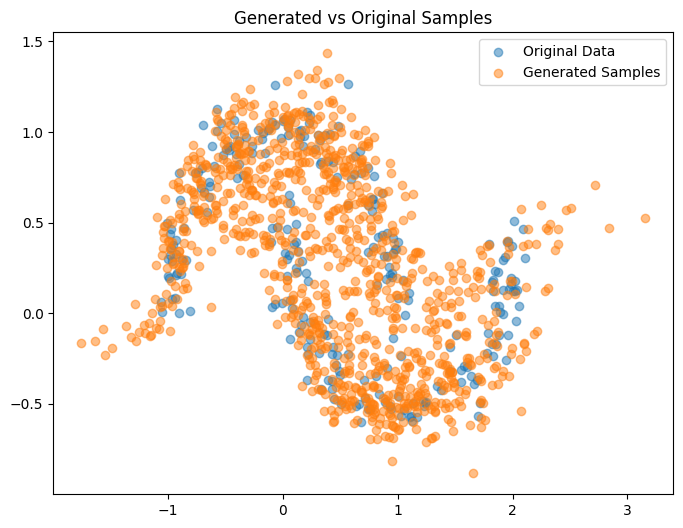

In [49]:
# TODO: Generate and visualize samples:

# Generate samples from the trained flow
num_samples = 1000
samples = flow.sample(num_samples).cpu().detach().numpy()

# Generate samples from the original distribution
original_samples = next(iter(data_loader))[0].cpu().detach().numpy()

# Plot the samples
plt.figure(figsize=(8, 6))
plt.scatter(original_samples[:, 0], original_samples[:, 1], label='Original Data', alpha=0.5)
plt.scatter(samples[:, 0], samples[:, 1], label='Generated Samples', alpha=0.5)
plt.title('Generated vs Original Samples')
plt.legend()
plt.show()


Visualize the evolution of the Normalizing Flows model.

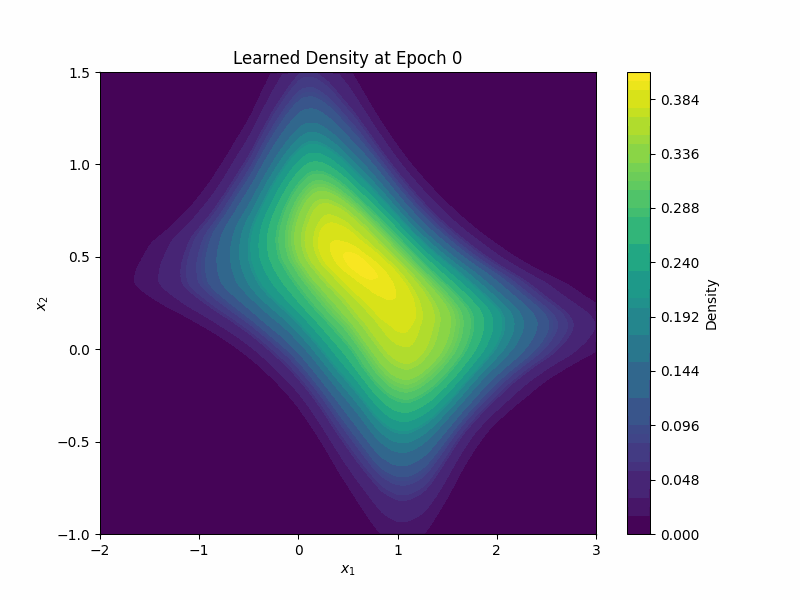

In [50]:
gif_path = create_gif()